# Machine Learning - Project 3

### Team 06 members:

Mauro Travieso Pena

Quoc Huy Luong

Ngoc Bao Tran


In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

Using TensorFlow backend.


python 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
keras version 2.2.4
tensorflow version 1.14.0


# Download the Flickr8K Dataset

Flilckr8K contains 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## The location of the Flickr8K_ photos 
drive_path = "/content/drive/My Drive/Colab Notebooks"
dir_Flickr_jpg = drive_path + "/Flickr8k_Dataset"

## The location of the caption file
#dir_Flickr_text = "../Flickr8k/Flickr8k.token.txt"
dir_Flickr_text = drive_path + "/Flickr8k_text/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8094


# Preliminary analysis

## Import caption data

## Load the text data and save it into a panda dataframe df_txt.

* filename : jpg file name
* index : unique ID for each caption for the same image
* caption : string of caption, all in lower case

In [0]:
## read in the Flickr caption data
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names: {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names: 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

Let's have a look at some of the pictures together with the captions.

The 5 captions for each image share many common words and very similar meaning. Some sentences finish with "." but not all.

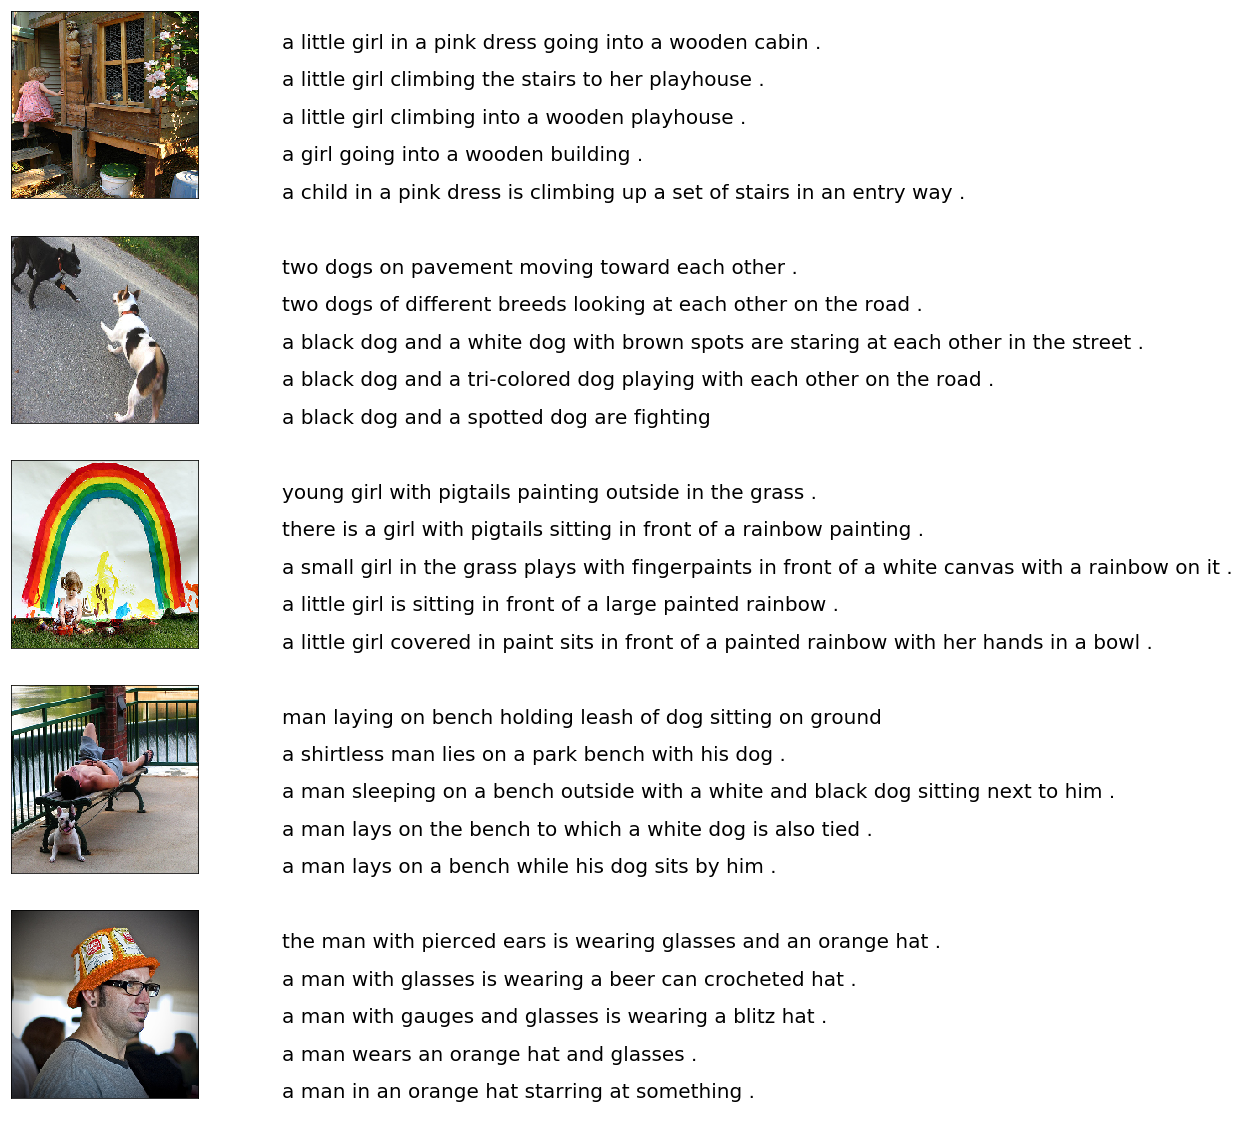

In [0]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

# Data preparation

We prepare text and image data separately.

## Text preparation

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [0]:
df_txt['caption'].unique()

array(['a child in a pink dress is climbing up a set of stairs in an entry way .',
       'a girl going into a wooden building .',
       'a little girl climbing into a wooden playhouse .', ...,
       'a person in a red shirt climbing up a rock face covered in assist handles .',
       'a rock climber in a red shirt .',
       'a rock climber practices on a rock climbing wall .'], dtype=object)

In [0]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    #dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = pd.DataFrame.from_dict(ct, orient='index').reset_index()
#     dfword.head(3)
    dfword.columns=['word','count']
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

df_txt.head()
dfword = df_word(df_txt)
dfword.head(10)

Vocabulary Size: 8918


,word,count
0,a,62989
1,.,36581
2,in,18975
3,the,18419
4,on,10744
5,is,9345
6,and,8852
7,dog,8136
8,with,7765
9,man,7266


In [0]:
dfword.shape

(8918, 2)

## The most and least frequently appearing words

The most common words are articles such as "a", or "the", or punctuations.

These words do not have much infomation about the data.

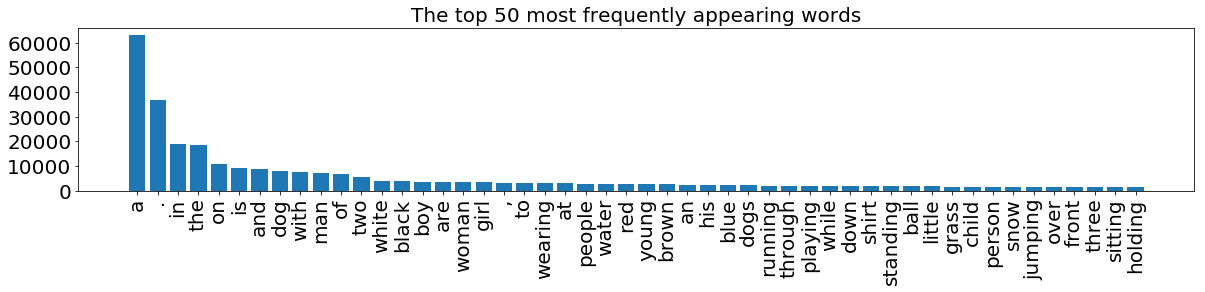

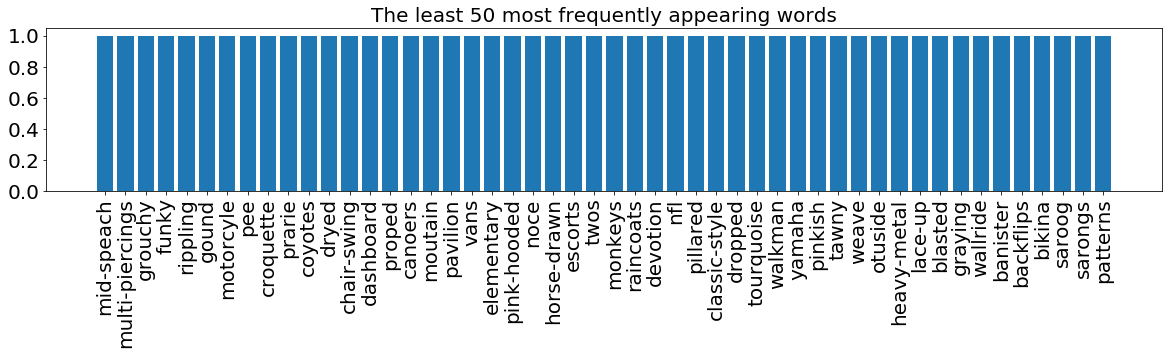

In [0]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In order to clean the caption, I will create three functions that:

* remove punctuation
* remove single character
* remove numeric characters

To see how these functions work, I will process a single example string using these three functions.

In [0]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','', string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


# Clean all captions

Using the three functions, I will clean all captions.

In [0]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

After cleaning, the vocabularly size get reduced by about 200.

Vocabulary Size: 8763


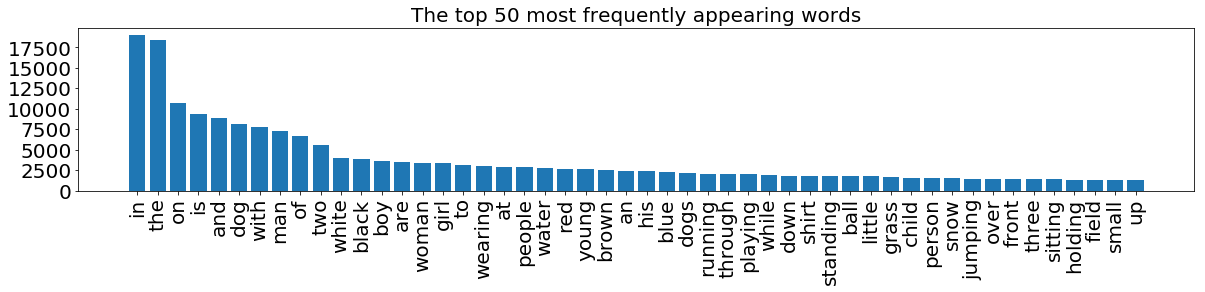

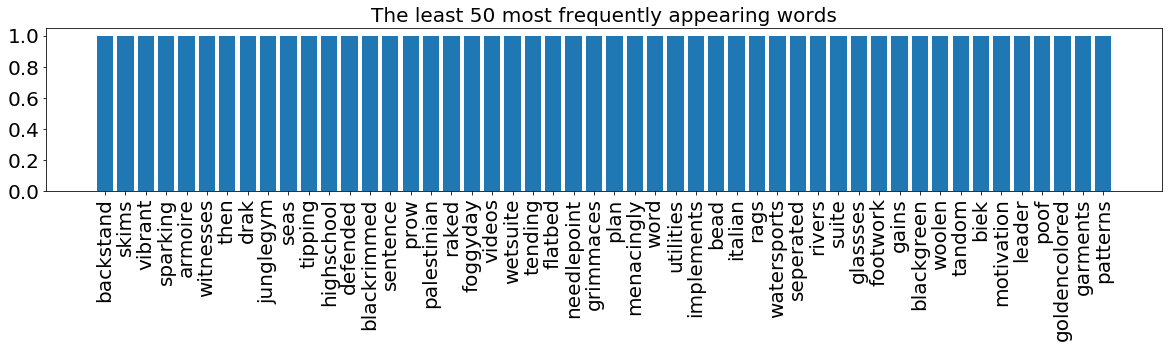

In [0]:
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

# Add start and end sequence tokens

In [0]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

# Image preparation

##Create features for each image using VGG16's pre-trained networks

Read in the pre-trained network. Notice that this network takes input of size (224,224,3). The output layer contains 1,000 nodes.

I downloaded weights from here to my local computer at ../output/ by:

wget 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5' --no-check-certificate

In [0]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights 
#modelvgg.load_weights("../output/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.load_weights(drive_path + "/vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

W0813 19:30:07.704875 140467310098304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 19:30:07.707575 140467310098304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 19:30:07.721074 140467310098304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 19:30:07.771421 140467310098304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0813 19:30:11.956980 140467310098304 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

VGG16 is developed to classify images into 1,000 different classes. As I am not using VGG16 for the sake of the classification but I just need it for extracting features, I will remove the last layer from the network.

In [0]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Images

In [0]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

import numpy as np

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

# Visualization of the VGG16 features

For each image, 4096 features are created. As I cannot visualize the 4096 dimensional space, I will create 2 dimentional representation of the space using PCA and visualize the distribution of the sample images.

In [0]:
from sklearn.decomposition import PCA
# list(images.values())
# images['432248727_e7b623adbf.jpg']
encoder = np.array(list(images.values()))
# encoder
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

# Do photo features make sense?

I manually selected similar images that are creating clusters. Namely I created red, green, magenta, blue, yellow and purple clusters. From each cluster, I plotted the original images. As you see, images from the same clusters tend to be very similar:

* red: many people are in one image
* green: dogs on green, yard or on bed
* magenta: dogs in snow or with water splash
* blue: guys doing sports with helmets
* yellow: not sure what these are?? I see many pictures are densely clustered around this area and

Photo features seem to make sense!

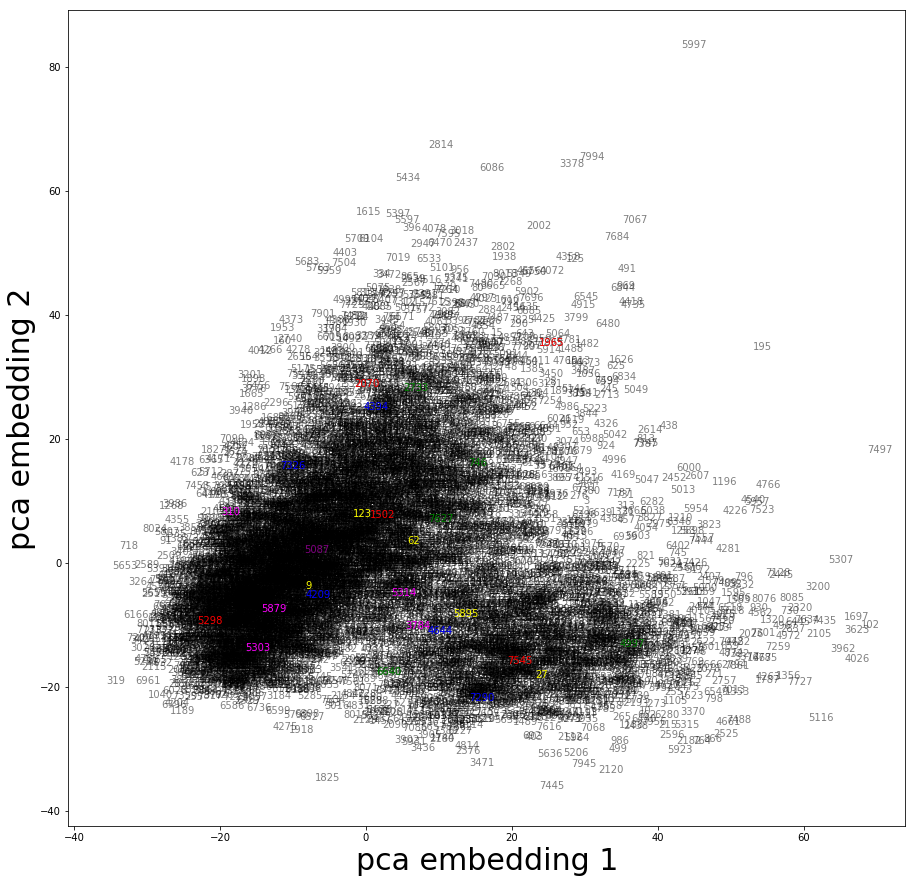

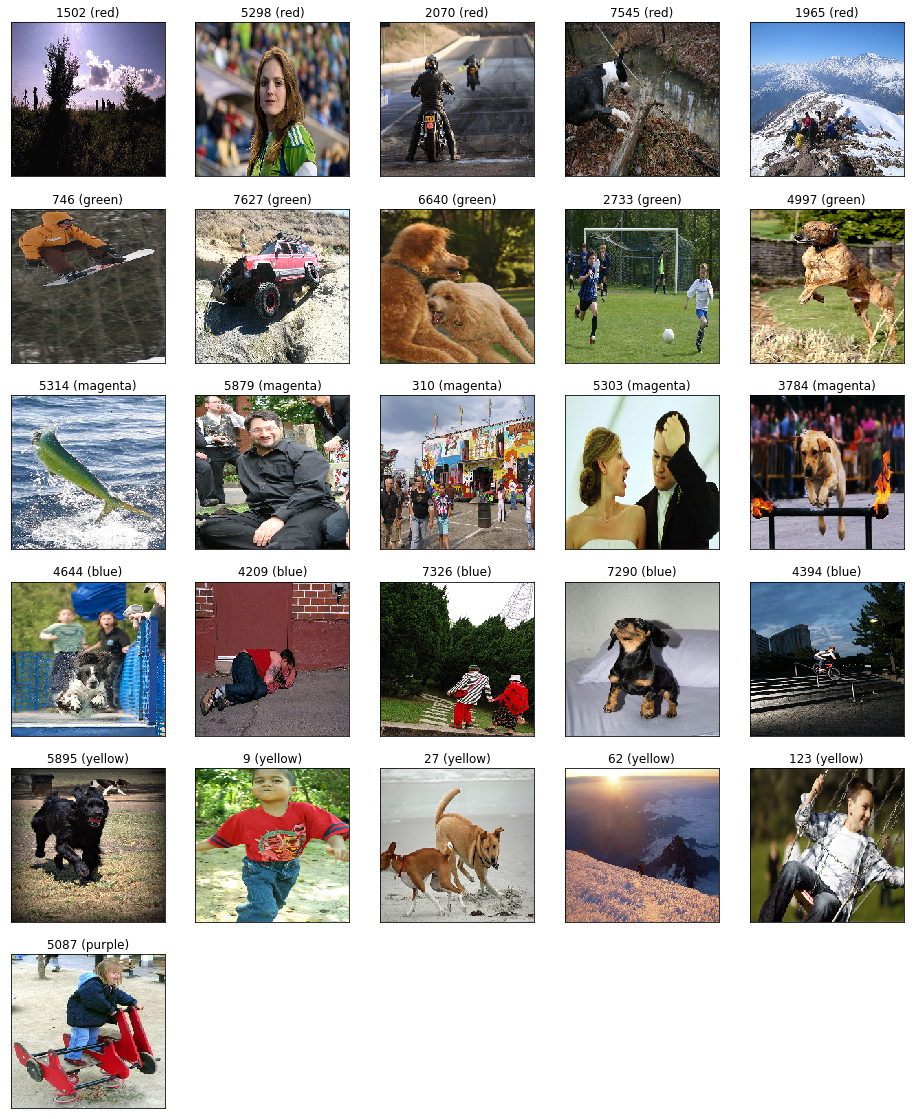

In [0]:
## some selected pictures that are creating clusters
picked_pic = OrderedDict()
picked_pic["red"]     = [1502,5298,2070,7545,1965]
picked_pic["green"]   = [746,7627,6640,2733, 4997]
picked_pic["magenta"] = [5314,5879,310,5303, 3784]
picked_pic["blue"]    = [4644,4209,7326,7290,4394]
picked_pic["yellow"]  = [5895,9,27,62,123]
picked_pic["purple"]  = [5087]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5)
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()


## plot of images 
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

# Link the text and image data

In this dataset, a single image has 5 captions. I will only use one caption out of 5 for simplicity.

Each row of the dtexts and dimages contain the same info. Remove captions (or images) that do not have corresponding images (or captions).

In [0]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

# Tokenizer

Change character vector to integer vector using Tokenizer

In [0]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


# Split between training and testing data

In [0]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)



The maximum length of captions

In [0]:
maxlen = np.max([len(text) for text in dtexts])

The final preprocessing so that the data can be used as input and output of the Keras model.

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


# Model

This model takes two inputs:

* 4096-dimensional image features from pre-trained VGG model
* tokenized captions up to tth word.

The single output is:

* tokenized t+1th word of caption

# Prediction

Given the caption prediction up to the tth word, the model can predict the t+1st word in the caption, and then the input caption can be augmented with the predicted word to contain the caption up to the t+1th word. The augmented caption up to the t+1st word can, in turn, be used as input to predict the t+2nd word in caption. The process is repeated until the "endseq" is predicted.

# A bit more detail:

* [Image] 4096-dimensional image features from pre-trained VGG model
  * The image feature is passed to fully connected layer with 256 hidden units.
* [Caption up to t] tokenized captions up to tth word.

  * The tokenized caption up to tth time point is passed to embedding layer where each word is represented with a "dim_embedding" dimensional vector. This means that a single caption is represented as many time series of length "max_len".
  * The time series are passed to LSTM with 256 hidden states, and then a single output at the final time point is passed to the higher layer.
* The networks are merged by simply adding the two vectors of size 256.

* The vector of length 256 is passed to two dense layers and the final dense layer return probability that the t+1st word is kth word in the vocabulary (k=1,...,4476).

In [0]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

# Model training

In [0]:
# fit model
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

In [0]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

# Validation loss and training loss over epochs

The model over fit very quickly. This makes sense considering the small size of our data.

In [0]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Prediction
Prediction of testing image makes sense!

In [0]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

# Bilingual evaluation understudy (BLEU)

In [0]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I do like dog"
references = [reference.split()] ## references must be a list containing list. 

According to BLEU the two sentences are reasonably similar.

In [0]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))  

If I change the hypothesis sentence a bit, this worsen the BLEU.

In [0]:
hypothesis2 = "I love dog!".split()
print("BLEU={:4.3f}".format(sentence_bleu(references,  hypothesis2))) 

# 2-gram BLEU calculation step by step
The main calculation of BLEU is done in modified_precision(references, hypothesis, n). So Let's try to understand this method.

As the first step, given "n" of n-gram, compute n-gram and count the frequency of each n-gram.

In [0]:
from nltk.util import ngrams
n = 2
# Extracts all ngrams in hypothesis
# Set an empty Counter if hypothesis is empty.
counts = Counter(ngrams(hypothesis, n)) if len(hypothesis) >= n else Counter()
# Extract a union of references' counts.
counts

max_counts is a dictionary containing the same key as counts; i.e. the n-gram from the hypothesis is a key. It records how many of the ngram from hypothesis exists in each of the reference sentences.

In [0]:
max_counts = {}
for reference in references:
    reference_counts = Counter(ngrams(reference, n)) if len(reference) >= n else Counter()
    for ngram in counts: ## ngram from hypothesis
        max_counts[ngram] = max(max_counts.get(ngram, 0),
                                reference_counts[ngram])

max_counts

Modified precision is:

In [0]:
# Assigns the intersection between hypothesis and references' counts.
clipped_counts = {ngram: min(count, max_counts[ngram])
                      for ngram, count in counts.items()}

numerator = sum(clipped_counts.values())
# Ensures that denominator is minimum 1 to avoid ZeroDivisionError.
# Usually this happens when the ngram order is > len(reference).
denominator = max(1, sum(counts.values()))

modified_precision = numerator/float(denominator)
print(modified_precision)

Compute the penalty:

In [0]:
ref_len = len(reference)
hyp_len = float(len(hypothesis))
brevity_penalty = np.exp(1 - ref_len / hyp_len)
print("reference length = {:1.0f}, hypothesis length = {:1.0f}, penalty = {:4.3f}".format(
    ref_len,hyp_len,brevity_penalty))

2-gram BLEU is:

In [0]:
brevity_penalty*modified_precision

We can also calculate the 2-gram BLEU using the sentence_bleu function by setting only the second position in weight as 1.

In [0]:
print("2-gram result:{}".format(sentence_bleu(references,hypothesis, weights=[0,1,0,0])))

#Back to image captioning problem

Now we understand what BLEU does and we are ready to calculate the BLEU for our test set.

In [0]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

# The mean BLEU value for testing data

In [0]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Plot the images with good captions (BLEU > 0.9) and bad captions (BLEU < 0.1)

In [0]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

# References

### https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html

### https://www.google.com/search?q=vgg16_weights_tf_dim_ordering_tf_kernels.h5&oq=vgg16_weights_tf_dim_ordering_tf_kernels.h5&aqs=chrome..69i57.9802j0j0&sourceid=chrome&ie=UTF-8